In [3]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [4]:
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 98% 265M/271M [00:10<00:00, 20.4MB/s]
100% 271M/271M [00:10<00:00, 26.7MB/s]
 99% 537M/544M [00:20<00:00, 21.9MB/s]
100% 544M/544M [00:21<00:00, 27.1MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 114MB/s]


In [ ]:
!unzip train.zip 
!unzip test.zip 

In [0]:
from os import listdir
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

In [0]:
train='train'
label = []
for file in listdir(train):
    category = file.split('.')[0]
    if category=='dog':
        label.append('dog')
    if category == 'cat' :
        label.append("cat")
train_df = pd.DataFrame()
train_df['filename']=listdir(train)
train_df['label']=label

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test= train_test_split(train_df,test_size = 0.2,random_state = 42)
X_train=X_train.reset_index()
X_test=X_test.reset_index()

In [9]:
image_size =224
train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=15, shear_range=0.2, zoom_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest', width_shift_range=0.1, height_shift_range=0.1)
train_generator = train_datagen.flow_from_dataframe(X_train, train, x_col = "filename", y_col = "label",
                                class_mode = 'binary', target_size = (image_size,image_size), batch_size=16)

Found 20000 validated image filenames belonging to 2 classes.


1.0


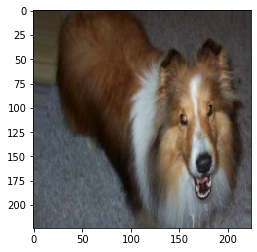

In [10]:
for i,j in train_generator:
    plt.imshow(i[2])
    print(j[2])
    break

In [11]:
image_size =224
validation_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=15, shear_range=0.2, zoom_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest', width_shift_range=0.1, height_shift_range=0.1)
validation_generator  = validation_datagen.flow_from_dataframe(X_test, train, x_col = "filename", y_col = "label",
                                class_mode = 'binary', target_size = (image_size,image_size), batch_size=16)

Found 5000 validated image filenames belonging to 2 classes.


In [0]:
from keras.applications import VGG16
import keras.optimizers
from keras.models import Model,Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
import numpy as np

In [13]:
image_size = 224
input_shape = (image_size, image_size, 3)
VGG16_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
model = Sequential()
model.add(VGG16_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
VGG16_model.trainable = True
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])
model.summary()





58892288/58889256 [==============================] - 6s 0us/step







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_2 (Dense)              (N

In [14]:
history = model.fit_generator(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=7500//16,
    steps_per_epoch=17500//16,
)



Epoch 1/5
1093/1093 [==============================] - 410s 375ms/step - loss: 0.2168 - acc: 0.8991 - val_loss: 0.1125 - val_acc: 0.9561
Epoch 2/5
1093/1093 [==============================] - 403s 368ms/step - loss: 0.0850 - acc: 0.9659 - val_loss: 0.0810 - val_acc: 0.9702
Epoch 3/5
1093/1093 [==============================] - 400s 366ms/step - loss: 0.0622 - acc: 0.9747 - val_loss: 0.0636 - val_acc: 0.9758
Epoch 4/5
1093/1093 [==============================] - 398s 364ms/step - loss: 0.0570 - acc: 0.9771 - val_loss: 0.0609 - val_acc: 0.9790
Epoch 5/5
1093/1093 [==============================] - 398s 364ms/step - loss: 0.0481 - acc: 0.9800 - val_loss: 0.0580 - val_acc: 0.9789


In [0]:
test='test'
id = []
for file in listdir(test):
    category = file.split('.')[0]
    id.append(category)
final = pd.DataFrame()
final['name']=listdir(test)

In [18]:
image_size =224
test_datagen = ImageDataGenerator(rescale = 1./255 , rotation_range=15, shear_range=0.2,
    zoom_range=0.2, horizontal_flip=True, fill_mode='nearest', width_shift_range=0.1,height_shift_range=0.1)
test_generator = test_datagen.flow_from_dataframe(final, 'test', x_col = "name", y_col=None,
                                class_mode=None, target_size = (image_size,image_size), batch_size=16)

Found 12500 validated image filenames.


In [0]:
samples = final.shape[0]
predict = model.predict_generator(test_generator, steps=np.ceil(samples/16))
final['category']=predict

In [0]:
final_submission = final.copy()

In [0]:
final_submission['id'] = final_submission['name'].str.split('.').str[0]
final_submission['label'] = final_submission['category']
final_submission['label']=np.clip(final_submission['label'],0.04,0.96)
final_submission.drop(['name', 'category'], axis=1, inplace=True)
final_submission.to_csv('MSBA.Session001AnunayGupta.csv', index=False)

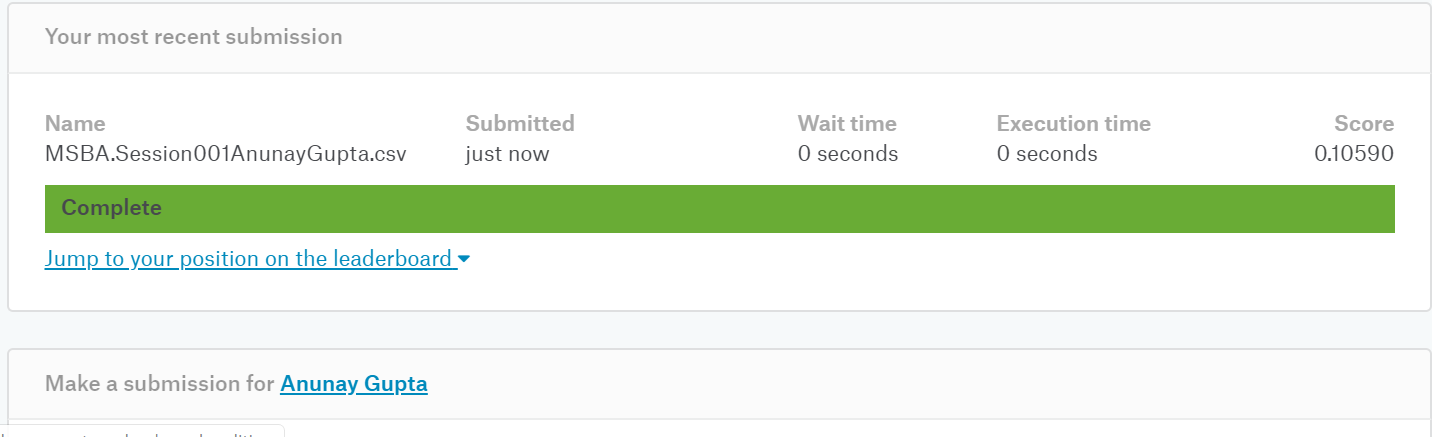

In [24]:
image_path = '/content/dogsvsCat.PNG'
from IPython.display import display, Image
display(Image(filename= image_path))



# 